Este cuaderno resume el procedimiento llevado a cabo ......

Estos son todos los paquetes empleados para la implementación:

In [1]:
%pylab inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


1) Se importan los datos suministrados por Kaggle [PONER LINK]

In [2]:
data_train = pd.read_csv(os.path.join('.','train.csv'))
data_test = pd.read_csv(os.path.join('.','test.csv'))

2) Para ver el formato en el que vienen los datos:

In [3]:
data_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
168,169,0,1,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,NaN,S
676,677,0,3,"Sawyer, Mr. Frederick Charles",male,24.5,0,0,342826,8.0500,NaN,S
686,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
423,424,0,3,"Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria ...",female,28.0,1,1,347080,14.4000,NaN,S
428,429,0,3,"Flynn, Mr. James",male,NaN,0,0,364851,7.7500,NaN,Q
550,551,1,1,"Thayer, Mr. John Borland Jr",male,17.0,0,2,17421,110.8833,C70,C
238,239,0,2,"Pengelly, Mr. Frederick William",male,19.0,0,0,28665,10.5000,NaN,S
304,305,0,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,A/5 2466,8.0500,NaN,S
591,592,1,1,"Stephenson, Mrs. Walter Bertram (Martha Eustis)",female,52.0,1,0,36947,78.2667,D20,C
442,443,0,3,"Petterson, Mr. Johan Emil",male,25.0,1,0,347076,7.7750,NaN,S


3) Se pueden usar diferentes tipos de gráficas para visualizar los diferentes datos, para así tener una primera aproximación entre la relación entre las características y la supervivencia de cada pasajero.

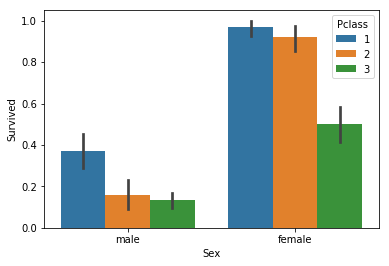

In [4]:
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=data_train);

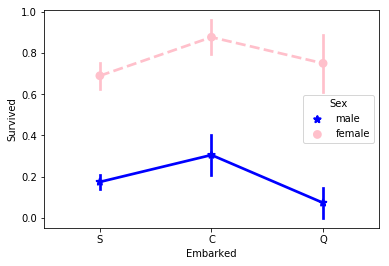

In [5]:
sns.pointplot(x="Embarked", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

4) Se modifican algunas características suministradas para simplificarlas o para organizarlas de manera más efectiva.

4.1) Para las edades se crean grupos dados los rango de edades suministrados:

In [6]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df


4.2) Para la caracteristica de cabinas se elije únicamente el primer elemento, que corresponde a la letra de la zona en la que encontraba la cabina y se asume que el número es irrelevante.

In [7]:
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

In [25]:
data_train.Embarked.apply(lambda x: x[0])

TypeError: 'float' object is not subscriptable

4.3) Para las tarifas que pagó cada persona se hace un análisis etadístico y se agrupan dependiendo el cuartil al que pertenezcan.

In [8]:
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

4.4) Para los nombres se va a tener en cuenta únicamente el apellido y el prefijo cono (Mr., Mrs., etc.). [En el código original se separaban los atributos según los espacios, pero esto fallaba para apellidos compuestos como Vander Cruyssen, por lo tanto, se implementa este código corregido].

In [9]:
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(',')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(',')[1])
    df['NamePrefix'] = df.NamePrefix.apply(lambda x: x.split(' ')[1])
    return df    

4.5) Por último se eliminan datos que no se incluiran en el análisis como número de tiquete y nombre. [En el código original se quitaba también el lugar de embarcación, pero dada la vista en la segunda gráfica de l punto 3) se decide dejar esta característica].

In [10]:
def drop_features(df):
    return df.drop(['Ticket', 'Name'], axis=1)

5) Se hace implementa una función general para realizar todo el manejo de los datos.

In [11]:
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [12]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.sample(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
613,614,0,3,male,Unknown,0,0,1_quartile,N,Q,Horgan,Mr.
118,119,0,1,male,Student,0,1,4_quartile,B,C,Baxter,Mr.
269,270,1,1,female,Young Adult,0,0,4_quartile,C,S,Bissette,Miss.
508,509,0,3,male,Young Adult,0,0,3_quartile,N,S,Olsen,Mr.
391,392,1,3,male,Student,0,0,1_quartile,N,S,Jansson,Mr.


6) Se muestran los resultados de la simplificaicón en las siguientes gráficas.

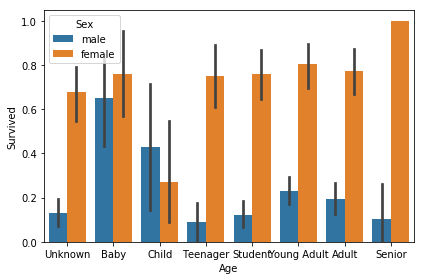

In [13]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train)
plt.tight_layout();

6.1) En la gráfica de rango de edad contra el promedio de supervivencia, el primer elemento relevante es que todas las mujeres mayores de 60 años sobrevivieron y en general las mujeres presentan un mayor promedio de supervivencia, excepto para las niñas (en el rango entre 5-12 años).

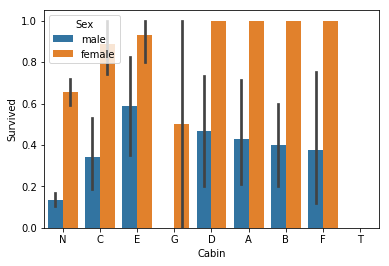

In [14]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

6.2) Para los datos de la cabina ocupada, todas las mujeres en las cabinas D,A,B, y F sobrevivieron puede ser por dos razones, la primera es que fueran mujeres pertenecientes a la primera clase y se les otorgara algún tipo de prioridad o la segunda es que hayan estado más cerca a los botes salvavidas. 

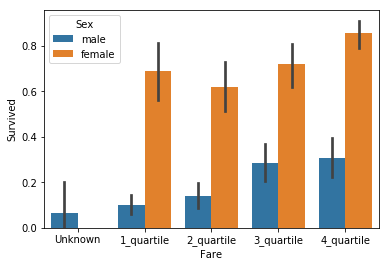

In [15]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

6.3) En esta gráfica de tarifa contra tasa de supervivencia se hace más evidente la relación entre el precio pagado (relacionado con la clase) y  la supervivencia de los pasajeros, especialemente en los hombres, que a medida que aumenta la tarifa la tasa de supervivencia aumenta. Para los casos desconocidos se asume que son personas que se colaron, razón por la cual era muy poco probable que recibieran un cupo en los botes salvavidas.

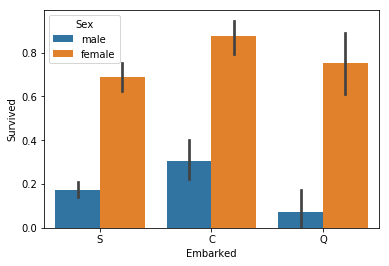

In [16]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

6.4) En la gráfica de lugar de embarcación contra supervivencia, se puede ver que los promedios más altos se encuentran para aquellas personas que embarcaron en C (Cherbourg, Francia) por lo tanto, a diferencia del código original, se decide incluir esta característica en el análisis.

7) Una forma de regularizar los datos es empleando el módulo de codificación de etiquetas del paquete de scikit-learn, que otorga valores numericos a las categorias creadas anteriormente.

In [17]:
def encode_features(df_train, df_test):
    features = ['Fare', 'Age', 'Cabin', 'Sex', 'Lname', 'NamePrefix', 'Embarked']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

In [18]:
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

TypeError: '<' not supported between instances of 'float' and 'str'

In [26]:
type(data_train.Embarked[5])

str